In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product, chain, combinations
from scipy import stats
from IPython.display import display, HTML
from datetime import datetime
%matplotlib inline

In [2]:
dayframes = {
    (0, 5*60+23): 'NIGHT',
    (5*60+24, 5*60+56): 'TWILIGHT',
    (5*60+57, 20*60+33): 'DAYLIGHT',
    (20*60+34, 21*60+6): 'TWILIGHT',
    (21*60+7, 24*60): 'NIGHT'
}

Detected_Activity_List = {
  0.0 : "IN_VEHICLE",
  1.0 : "ON_BICYCLE",
  2.0 : "ON_FOOT",
  3.0 : "STILL",
  4.0 : "UNKNOWN",
  5.0 : "TILTING",
  7.0 : "WALKING",
  8.0 : "RUNNING"
}

sensor_type_dict = {
    'MONITORING':-1,
    'INDOOR':-2,
    'GPS_SATELLITES':-3,
    'GPS_FIX_SATELLITES':-4,
    'GPS_FIX':-5,
    'DETECTED_ACTIVITY':-6,
    'WIFI_ACCESS_POINTS':-7,
    'BLUETOOTH_DEVICES':-8
}


ordered_columns = [
    'LUMINOSITY',

    'LUMINOSITY30S',
    'LAST_LUMINOSITY_WHEN_FAR',
    'LAST_LUMINOSITY30S_WHEN_FAR',
    'TIME_FROM_LAST_FAR',

    'WIFI_ACCESS_POINTS',
    'BLUETOOTH_DEVICES',
    'GPS_SATELLITES',
    'GPS_FIX_SATELLITES',
    'GPS_TIME_FROM_FIX',

    'PROXIMITY',
    'DAYLIGHT',
    'TWILIGHT',
    'NIGHT',
    'IN_VEHICLE',
    'ON_BICYCLE',
    'ON_FOOT',
    'STILL',
    'TILTING',
    'WALKING',
    'RUNNING',

    'INDOOR'
]

In [3]:
def preprocess_data(inputFile):
    df = pd.read_csv(inputFile)
    df.loc[:,'FileName'] = inputFile
    for index,row in df.iterrows():
        if  df.loc[index,'sensor_type'] == -1:
            df.loc[index,'sensor_type'] = sensor_type_dict[ row['sensor_name']]
    
    last_seen_values = {}
    sensor_types = df['sensor_name'].unique()
    for sensor_type in sensor_types:
        last_seen_values[sensor_type] = float('nan')

    proximity_name = ""
    light_name = ""

    for sensor_type in sensor_types:
        if 'proximity' in sensor_type.lower():
            proximity_name = sensor_type
            continue
        if 'light' in sensor_type.lower():
            light_name = sensor_type
    
    switchlist = []
    for _,row in df.iterrows():
        if row['sensor_name'] == 'INDOOR':
            switchlist.append(row['timestamp'])
    droplist = []
    for index,row in df.iterrows():
        if row['sensor_name'] != light_name:
            continue
        for switch in switchlist:
            if row['timestamp'] > switch - 3*1000 and row['timestamp'] < switch + 3*1000:
                droplist.append(index)
    df.drop(droplist, inplace=True)
    
    df_wide = df.pivot_table(index=['FileName','timestamp'], columns='sensor_name', values='value', aggfunc='first')

    last_gps_fix = -1
    last_lum_far = float('nan')
    time_last_far = -1
    is_far = True
    lumfar = {}
    for index,row in df_wide.iterrows():
        if row['MONITORING'] == 0:
            for sensor_type in sensor_types:
                last_seen_values[sensor_type] = float('nan')
            last_gps_fix = -1
            last_lum_far = float('nan')
            time_last_far = -1
            is_far = True
            lumfar = {}
        else:
            if row['GPS_FIX'] > 0:
                last_gps_fix = index[1]
            if last_gps_fix == -1:
                df_wide.loc[index,'GPS_FIX'] = -1
            else:
                df_wide.loc[index, 'GPS_FIX'] = (index[1] - last_gps_fix)/1000
            if not math.isnan(row[proximity_name]):
                is_far = row[proximity_name] > 0.0
            if (not math.isnan(row[light_name])) and is_far:
                last_lum_far = row[light_name]
            if (is_far or time_last_far == -1) and not math.isnan(last_lum_far):
                time_last_far = index[1]
                lumfar[index[1]] = last_lum_far
            if time_last_far == -1:
                time_last_far = index[1]
            df_wide.loc[index, "TIME_FROM_LAST_FAR"] = (index[1] - time_last_far)/1000
            df_wide.loc[index, 'LAST_LUMINOSITY_WHEN_FAR'] = last_lum_far
            lum30s = df[(df['timestamp'] >= (index[1] - 30*1000)) & (df['timestamp'] <= index[1]) & (df['sensor_name'] == light_name)]['value'].mean()
            df_wide.loc[index, 'LUMINOSITY30S'] = lum30s
            lumfar = {k: v for k, v in lumfar.items() if k >= (time_last_far - 30*1000)}
            if len(lumfar.values()) > 0:
                lumsum = 0
                for value in lumfar.values():
                    lumsum += value
                lum30sFar = lumsum/len(lumfar.values())
            else:
                lum30sFar = last_lum_far
            df_wide.loc[index, 'LAST_LUMINOSITY30S_WHEN_FAR'] = lum30sFar
            for sensor_type in sensor_types:
                if math.isnan(row[sensor_type]):
                    df_wide.loc[index,sensor_type] = last_seen_values[sensor_type]
                last_seen_values[sensor_type] = row[sensor_type] 

    for index,row in df_wide.iterrows():
        containsNaN = 0.0
        for feature in df_wide.columns:
            if feature != 'containsNaN' and math.isnan(row[feature]):
                containsNaN = 1.0
                break
        df_wide.loc[index,'containsNaN'] = containsNaN
    
    for index,row in df_wide.iterrows():
        dt = datetime.fromtimestamp(index[1] / 1000)
        minofday = dt.hour * 60 + dt.minute
        for key in dayframes.keys():
            if minofday < key[1] and minofday > key[0]:
                 df_wide.loc[index, 'TIME_OF_DAY'] = dayframes[key]

    for value in dayframes.values(): 
        df_wide[value] = df_wide['TIME_OF_DAY'] == value  

    del df_wide['TIME_OF_DAY']

    df_wide = df_wide[(df_wide['MONITORING'] == 1.0) & (df_wide['containsNaN'] == 0.0) & (df_wide['GPS_FIX'] != -1)] 
    del df_wide['containsNaN']

    df_wide.loc[(df_wide[proximity_name] > 0.0),proximity_name] = 1

    for key in Detected_Activity_List.keys(): 
        df_wide[Detected_Activity_List[key]] = df_wide['DETECTED_ACTIVITY'] == key

    df_wide.sort_values(['timestamp'], inplace=True)
    del df_wide['MONITORING']
    del df_wide['DETECTED_ACTIVITY']
    del df_wide['UNKNOWN']
    
    cols = [sensor_type for sensor_type in df_wide.columns.to_list() if sensor_type != proximity_name]
    cols.append(proximity_name)
    df_wide = df_wide[cols].replace(True,1.0).replace(False,0.0)
    df_wide.rename(columns={light_name: "LUMINOSITY", proximity_name: "PROXIMITY", 'GPS_FIX': "GPS_TIME_FROM_FIX"}, inplace=True)
    df_wide = df_wide[ordered_columns]
    return df_wide

from os import walk,path

dfs = []
root_directory = "datasets"
_, _, filenames = next(walk(root_directory))
for filename in filenames:
    print(filename)
    if not filename.endswith('.csv'):
        continue
    x = path.join(root_directory,filename)
    dfs.append(preprocess_data(x))
    
df_wide = pd.concat(dfs)
    
df_wide

collected-data_N2.csv
collected-data_N.csv


sensor_name                                   LUMINOSITY  LUMINOSITY30S  \
FileName                       timestamp                                  
datasets/collected-data_N2.csv 1621450647694        67.0      38.611111   
                               1621450651900        67.0      38.611111   
                               1621450665246        67.0      37.312500   
                               1621450729293        54.0      54.000000   
                               1621450729352        35.0      44.500000   
...                                                  ...            ...   
datasets/collected-data_N.csv  1621366255505        70.0      72.304348   
                               1621366255622        83.0      72.750000   
                               1621366255740        71.0      72.680000   
                               1621366256558        66.0      72.423077   
                               1621366257259        60.0      71.962963   

sensor_name                                   LAST_LUMINOSITY_WHEN_FAR  \
FileName                       timestamp                                 
datasets/collected-data_N2.csv 1621450647694                      67.0   
                               1621450651900                      67.0   
                               1621450665246                      67.0   
                               1621450729293                      54.0   
                               1621450729352                      35.0   
...                                                                ...   
datasets/collected-data_N.csv  1621366255505                      70.0   
                               1621366255622                      83.0   
                               1621366255740                      71.0   
                               1621366256558                      66.0   
                               1621366257259                      60.0   

sensor_name                                   LAST_LUMINOSITY30S_WHEN_FAR  \
FileName                       timestamp                                    
datasets/collected-data_N2.csv 1621450647694                    41.952381   
                               1621450651900                    43.090909   
                               1621450665246                    43.250000   
                               1621450729293                    60.500000   
                               1621450729352                    52.000000   
...                                                                   ...   
datasets/collected-data_N.csv  1621366255505                    72.500000   
                               1621366255622                    72.920000   
                               1621366255740                    72.846154   
                               1621366256558                    72.592593   
                               1621366257259                    72.142857   

sensor_name                                   TIME_FROM_LAST_FAR  \
FileName                       timestamp                           
datasets/collected-data_N2.csv 1621450647694                 0.0   
                               1621450651900                 0.0   
                               1621450665246                 0.0   
                               1621450729293                 0.0   
                               1621450729352                 0.0   
...                                                          ...   
datasets/collected-data_N.csv  1621366255505                 0.0   
                               1621366255622                 0.0   
                               1621366255740                 0.0   
                               1621366256558                 0.0   
                               1621366257259                 0.0   

sensor_name                                   WIFI_ACCESS_POINTS  \
FileName                       timestamp                           
datasets/collected-data_N2.csv 1621450

In [4]:
print(df_wide['INDOOR'].value_counts())
df_wide.drop_duplicates(inplace=True)
print(df_wide['INDOOR'].value_counts())
indoor_count = df_wide[df_wide['INDOOR'] == 1.0]['INDOOR'].count()
outdoor_count = df_wide[df_wide['INDOOR'] == 0.0]['INDOOR'].count()
bias = abs(indoor_count - outdoor_count)
print("Bias:", bias)
above = 1.0 if indoor_count > outdoor_count else 0.0

0.0    22831
1.0     5441
Name: INDOOR, dtype: int64
0.0    22831
1.0     5440
Name: INDOOR, dtype: int64
Bias: 17391


In [5]:
if bias > 0:
    sample = df_wide[df_wide['INDOOR'] == above].sample(n=bias)
    df_wide.drop(df_wide[df_wide.index.isin(sample.index)].index, inplace=True)
print(df_wide['INDOOR'].value_counts())

0.0    5440
1.0    5440
Name: INDOOR, dtype: int64


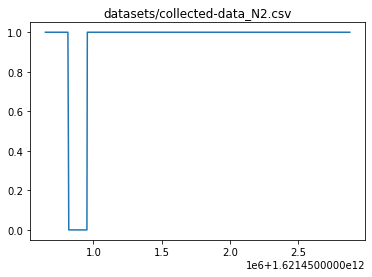

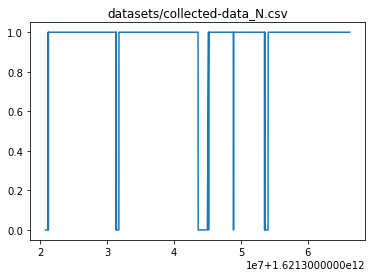

In [6]:
last_filename = None
time = []
indoor = []
for index,row in df_wide.iterrows():
    filename = index[0]
    if last_filename == None:
        last_filename = filename
    if last_filename != filename:
        plt.plot(time,indoor)
        plt.title(last_filename)
        plt.show()
        plt.close()
        time = []
        indoor = []
        last_filename = filename
    time.append(index[1])
    indoor.append(row['INDOOR'])
plt.plot(time,indoor)
plt.title(last_filename)
plt.show()
plt.close()

In [7]:
descb = df_wide.describe()
del descb['INDOOR']
descb

sensor_name,LUMINOSITY,LUMINOSITY30S,LAST_LUMINOSITY_WHEN_FAR,LAST_LUMINOSITY30S_WHEN_FAR,TIME_FROM_LAST_FAR,WIFI_ACCESS_POINTS,BLUETOOTH_DEVICES,GPS_SATELLITES,GPS_FIX_SATELLITES,GPS_TIME_FROM_FIX,...,DAYLIGHT,TWILIGHT,NIGHT,IN_VEHICLE,ON_BICYCLE,ON_FOOT,STILL,TILTING,WALKING,RUNNING
count,10880.000000,10880.000000,10880.000000,10880.000000,10880.000000,10880.000000,10880.000000,10880.000000,10880.0,10880.000000,...,10880.000000,10880.000000,10880.000000,10880.0,10880.0,10880.000000,10880.000000,10880.000000,10880.0,10880.0
mean,544.502022,571.630610,921.714154,2549.161525,63.549966,11.894210,5.007996,39.247702,0.0,66.234271,...,0.916636,0.025184,0.045772,0.0,0.0,0.432077,0.406526,0.004687,0.0,0.0
std,3076.535984,2398.955731,3109.025614,4465.049865,110.142690,8.261219,5.534874,3.566879,0.0,285.643396,...,0.276444,0.156690,0.209000,0.0,0.0,0.495388,0.491207,0.068308,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
25%,1.000000,1.000000,26.000000,37.781593,0.000000,5.000000,0.000000,37.000000,0.0,15.244750,...,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
50%,2.000000,17.398276,149.000000,365.032158,0.000000,11.000000,4.000000,39.000000,0.0,31.454000,...,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
75%,50.000000,108.843068,432.000000,2957.512195,94.141250,18.000000,6.000000,42.000000,0.0,49.436000,...,1.000000,0.000000,0.000000,0.0,0.0,1.000000,1.000000,0.000000,0.0,0.0
max,32767.000000,27047.816619,32767.000000,27067.161932,2890.969000,35.000000,17.000000,44.000000,0.0,3865.247000,...,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,0.0,0.0


In [8]:
bypass_norm = ['PROXIMITY', 'DAYLIGHT', 'TWILIGHT', 'NIGHT', 'IN_VEHICLE', 'ON_BICYCLE', 'ON_FOOT', 'STILL', 'TILTING', 'WALKING', 'RUNNING']

for col in df_wide.columns:
    if col == 'INDOOR':
        continue
    if descb.at['max', col] == 0.0:
        descb.at['max', col] = 1.0
    if col in bypass_norm:
        descb.at['mean', col] = 0.0
        descb.at['std', col] = 1.0
        continue
    colMean = descb.at['mean', col]
    colStd = descb.at['std', col]
    if colMean == 0 and colStd == 0:
        descb.at['std', col] = 1.0
        continue
    df_wide[col] = df_wide[col].apply(lambda x: (x - colMean)/colStd)
    

df_wide.to_csv('preprocessed_data.csv')
descb.to_csv('meta.csv')

In [9]:
descb

sensor_name,LUMINOSITY,LUMINOSITY30S,LAST_LUMINOSITY_WHEN_FAR,LAST_LUMINOSITY30S_WHEN_FAR,TIME_FROM_LAST_FAR,WIFI_ACCESS_POINTS,BLUETOOTH_DEVICES,GPS_SATELLITES,GPS_FIX_SATELLITES,GPS_TIME_FROM_FIX,...,DAYLIGHT,TWILIGHT,NIGHT,IN_VEHICLE,ON_BICYCLE,ON_FOOT,STILL,TILTING,WALKING,RUNNING
count,10880.000000,10880.000000,10880.000000,10880.000000,10880.000000,10880.000000,10880.000000,10880.000000,10880.0,10880.000000,...,10880.0,10880.0,10880.0,10880.0,10880.0,10880.0,10880.0,10880.0,10880.0,10880.0
mean,544.502022,571.630610,921.714154,2549.161525,63.549966,11.894210,5.007996,39.247702,0.0,66.234271,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,3076.535984,2398.955731,3109.025614,4465.049865,110.142690,8.261219,5.534874,3.566879,1.0,285.643396,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.000000,1.000000,26.000000,37.781593,0.000000,5.000000,0.000000,37.000000,0.0,15.244750,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,2.000000,17.398276,149.000000,365.032158,0.000000,11.000000,4.000000,39.000000,0.0,31.454000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,50.000000,108.843068,432.000000,2957.512195,94.141250,18.000000,6.000000,42.000000,0.0,49.436000,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
max,32767.000000,27047.816619,32767.000000,27067.161932,2890.969000,35.000000,17.000000,44.000000,1.0,3865.247000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [10]:
df_wide

sensor_name                                   LUMINOSITY  LUMINOSITY30S  \
FileName                       timestamp                                  
datasets/collected-data_N2.csv 1621450647694   -0.155208      -0.222188   
                               1621450651900   -0.155208      -0.222188   
                               1621450665246   -0.155208      -0.222729   
                               1621450729293   -0.159433      -0.215773   
                               1621450729352   -0.165609      -0.219733   
...                                                  ...            ...   
datasets/collected-data_N.csv  1621366255505   -0.154233      -0.208143   
                               1621366255622   -0.150007      -0.207957   
                               1621366255740   -0.153908      -0.207987   
                               1621366256558   -0.155533      -0.208094   
                               1621366257259   -0.157483      -0.208285   

sensor_name                                   LAST_LUMINOSITY_WHEN_FAR  \
FileName                       timestamp                                 
datasets/collected-data_N2.csv 1621450647694                 -0.274914   
                               1621450651900                 -0.274914   
                               1621450665246                 -0.274914   
                               1621450729293                 -0.279095   
                               1621450729352                 -0.285206   
...                                                                ...   
datasets/collected-data_N.csv  1621366255505                 -0.273949   
                               1621366255622                 -0.269768   
                               1621366255740                 -0.273627   
                               1621366256558                 -0.275235   
                               1621366257259                 -0.277165   

sensor_name                                   LAST_LUMINOSITY30S_WHEN_FAR  \
FileName                       timestamp                                    
datasets/collected-data_N2.csv 1621450647694                    -0.561519   
                               1621450651900                    -0.561264   
                               1621450665246                    -0.561228   
                               1621450729293                    -0.557365   
                               1621450729352                    -0.559268   
...                                                                   ...   
datasets/collected-data_N.csv  1621366255505                    -0.554677   
                               1621366255622                    -0.554583   
                               1621366255740                    -0.554600   
                               1621366256558                    -0.554657   
                               1621366257259                    -0.554757   

sensor_name                                   TIME_FROM_LAST_FAR  \
FileName                       timestamp                           
datasets/collected-data_N2.csv 1621450647694           -0.576979   
                               1621450651900           -0.576979   
                               1621450665246           -0.576979   
                               1621450729293           -0.576979   
                               1621450729352           -0.576979   
...                                                          ...   
datasets/collected-data_N.csv  1621366255505           -0.576979   
                               1621366255622           -0.576979   
                               1621366255740           -0.576979   
                               1621366256558           -0.576979   
                               1621366257259           -0.576979   

sensor_name                                   WIFI_ACCESS_POINTS  \
FileName                       timestamp                           
datasets/collected-data_N2.csv 1621450